# Érmefelismerés Transfer Learninggel (VGG16)

A projekt célja egy olyan PyTorch-alapú neurális háló létrehozása volt, amely a saját magam által készített érmefotók alapján képes felismerni, melyik címlet szerepel a képen. Ehhez transfer learninget alkalmaztam: a VGG16 előre tanított modelljét vettem alapul, majd a saját képeimhez igazítottam. Mivel kevés nyers kép állt rendelkezésre, különböző augmentációkkal növeltem a változatosságot, hogy a háló robusztusabb legyen. A tanítást két lépésben végeztem: először csak a felső rétegeket tanítottam újra, majd finomhangoltam a háló utolsó konvolúciós blokkját is kis tanulási rátával. A végeredmény egy működő érmefelismerő modell lett, amely új képekre is képes becslést adni.

### Importok

In [1]:
import os
import glob
import random
import copy
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")


Device: cpu


### Adatok beolvasása

Adatok az `images/` mappában, 6 érmeosztály (5, 10, 20, 50, 100, 200 forint), mindből 50 kép.
A címkét a fájlnévből parszoljuk az első aláhúzás előtti rész alapján.


In [ ]:
DATA_DIR = 'data_dir'
class_names = ['5', '10', '20', '50', '100', '200']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

image_paths = sorted(glob.glob(os.path.join(DATA_DIR, '*.jpg')))
if not image_paths:
    raise FileNotFoundError(f"Nem található kép az {DATA_DIR} mappában.")

records = []
for path in image_paths:
    base = os.path.basename(path)
    label_name = base.split('_')[0]
    if label_name not in class_to_idx:
        raise ValueError(f"Ismeretlen címke a fájlnévből: {base}")
    records.append({
        'path': path,
        'label_name': label_name,
        'label_idx': class_to_idx[label_name],
    })

    df = pd.DataFrame(records)
    print(df.head())
    print('Osztályeloszlás:')
    print(df['label_name'].value_counts().sort_index())


                      path label_name  label_idx
0  images\100_forint_1.jpg        100          4
Osztályeloszlás:
label_name
100    1
Name: count, dtype: int64
                       path label_name  label_idx
0   images\100_forint_1.jpg        100          4
1  images\100_forint_10.jpg        100          4
Osztályeloszlás:
label_name
100    2
Name: count, dtype: int64
                       path label_name  label_idx
0   images\100_forint_1.jpg        100          4
1  images\100_forint_10.jpg        100          4
2  images\100_forint_11.jpg        100          4
Osztályeloszlás:
label_name
100    3
Name: count, dtype: int64
                       path label_name  label_idx
0   images\100_forint_1.jpg        100          4
1  images\100_forint_10.jpg        100          4
2  images\100_forint_11.jpg        100          4
3  images\100_forint_12.jpg        100          4
Osztályeloszlás:
label_name
100    4
Name: count, dtype: int64
                       path label_name  label_idx


Stratifikált osztás: 70% train, 15% val, 15% test, minden osztály arányosan jelenik meg mindhárom halmazban.


### Train/Val/Test kialakítása

In [3]:
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label_idx'], random_state=SEED)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label_idx'], random_state=SEED)

print('Train méret:', len(train_df))
print('Val méret  :', len(val_df))
print('Test méret :', len(test_df))

def show_distribution(name, subset):
    print(f"{name} eloszlás:")
    print(subset['label_name'].value_counts().sort_index())

show_distribution('Train', train_df)
show_distribution('Val', val_df)
show_distribution('Test', test_df)


Train méret: 210
Val méret  : 45
Test méret : 45
Train eloszlás:
label_name
10     35
100    35
20     35
200    35
5      35
50     35
Name: count, dtype: int64
Val eloszlás:
label_name
10     8
100    7
20     7
200    8
5      8
50     7
Name: count, dtype: int64
Test eloszlás:
label_name
10     7
100    8
20     8
200    7
5      7
50     8
Name: count, dtype: int64


### Augmentációk

Bemenet: 224×224 RGB, ImageNet normalizálással. Mérsékelt, de erős augmentáció (crop, forgatás, flip, enyhe jitter, ritka kis blur), val/test: átméretezés + center crop + normalizálás.


In [4]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


In [5]:
class CoinDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int, str]:
        row = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['label_idx'])
        return image, label, row['path']

train_dataset = CoinDataset(train_df, transform=train_transform)
val_dataset = CoinDataset(val_df, transform=val_test_transform)
test_dataset = CoinDataset(test_df, transform=val_test_transform)

print(f"Mintaszámok – train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")


Mintaszámok – train: 210, val: 45, test: 45


In [6]:
batch_size = 16
num_workers = 2 if torch.cuda.is_available() else 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

for images, labels, paths in train_loader:
    print(f"Train batch shape: {images.shape}")
    break

Train batch shape: torch.Size([16, 3, 224, 224])


### VGG16 utolsó kimeneti rétegének átalakítása

ImageNet-en tanult VGG16-ot használunk, a feature extractor rétegeit először fagyasztjuk, a classifier utolsó lineáris rétegét 6 kimenetre cseréljük. Később az utolsó konv blokkot feloldjuk kis lr-rel finomhangolásra.


In [7]:
weights = models.VGG16_Weights.IMAGENET1K_V1
model = models.vgg16(weights=weights)

for param in model.features.parameters():
    param.requires_grad = False

num_classes = len(class_names)
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(model.classifier)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)


### Tanulási paraméterek definiálsa

CrossEntropyLoss, kétfázisú tréning: 12 epoch csak a fej (lr=1e-4), majd az utolsó konv blokk feloldva további finomhangolás kis lr-rel (1e-5). ReduceLROnPlateau a validációs losson, legjobb modell mentése változatlan.


In [8]:
criterion = nn.CrossEntropyLoss()

head_lr = 1e-4
finetune_lr = 1e-5
stage1_epochs = 12
stage2_epochs = 10
total_epochs = stage1_epochs + stage2_epochs

def create_optimizer(lr):
    return optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, weight_decay=1e-4)

def create_scheduler(opt):
    return optim.lr_scheduler.ReduceLROnPlateau(
        opt,
        mode='min',
        factor=0.5,
        patience=2
    )

def unfreeze_last_conv_block(m, start_idx=24):
    for name, param in m.features.named_parameters():
        layer_idx = int(name.split('.')[0])
        param.requires_grad = layer_idx >= start_idx

optimizer = create_optimizer(head_lr)
scheduler = create_scheduler(optimizer)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())
best_state_path = 'best_vgg16_coins.pth'

print(f"Trainable param szám (head-only): {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Trainable param szám (head-only): 119,570,438


### Tanulási ciklus

In [9]:
def run_epoch(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for images, labels, _ in loader:
        images, labels = images.to(device), labels.to(device)
        if is_train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            if is_train:
                loss.backward()
                optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

for epoch in range(1, total_epochs + 1):
    if epoch == stage1_epochs + 1:
        unfreeze_last_conv_block(model)
        optimizer = create_optimizer(finetune_lr)
        scheduler = create_scheduler(optimizer)
        print(f"Fine-tuning indul: utolsó konv blokk szabad, lr={finetune_lr}")

    train_loss, train_acc = run_epoch(train_loader, model, criterion, optimizer)
    val_loss, val_acc = run_epoch(val_loader, model, criterion, optimizer=None)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, best_state_path)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    phase = 'head' if epoch <= stage1_epochs else 'finetune'
    print(f"Epoch {epoch}/{total_epochs} [{phase}] | Train loss: {train_loss:.4f} acc: {train_acc:.4f} | Val loss: {val_loss:.4f} acc: {val_acc:.4f} | Best val acc: {best_val_acc:.4f} | LR: {current_lr:.6f}")

model.load_state_dict(best_model_wts)


Epoch 1/22 [head] | Train loss: 1.7941 acc: 0.2333 | Val loss: 1.7256 acc: 0.2000 | Best val acc: 0.2000 | LR: 0.000100
Epoch 2/22 [head] | Train loss: 1.6134 acc: 0.3571 | Val loss: 1.6492 acc: 0.2444 | Best val acc: 0.2444 | LR: 0.000100
Epoch 3/22 [head] | Train loss: 1.4595 acc: 0.4571 | Val loss: 1.6792 acc: 0.2000 | Best val acc: 0.2444 | LR: 0.000100
Epoch 4/22 [head] | Train loss: 1.3942 acc: 0.4095 | Val loss: 1.4582 acc: 0.3556 | Best val acc: 0.3556 | LR: 0.000100
Epoch 5/22 [head] | Train loss: 1.1963 acc: 0.5476 | Val loss: 1.5884 acc: 0.3111 | Best val acc: 0.3556 | LR: 0.000100
Epoch 6/22 [head] | Train loss: 1.3206 acc: 0.4667 | Val loss: 1.4581 acc: 0.3111 | Best val acc: 0.3556 | LR: 0.000100
Epoch 7/22 [head] | Train loss: 1.1125 acc: 0.5571 | Val loss: 1.4061 acc: 0.4222 | Best val acc: 0.4222 | LR: 0.000100
Epoch 8/22 [head] | Train loss: 1.1307 acc: 0.5476 | Val loss: 1.4768 acc: 0.3778 | Best val acc: 0.4222 | LR: 0.000100
Epoch 9/22 [head] | Train loss: 0.9382 a

<All keys matched successfully>

### Tanulási és teszt eredmények (Loss/Accuraccy)

Az alábbiak a loss/accuracy görbéket mutatják, röviden ellenőrizzük a konvergenciát.


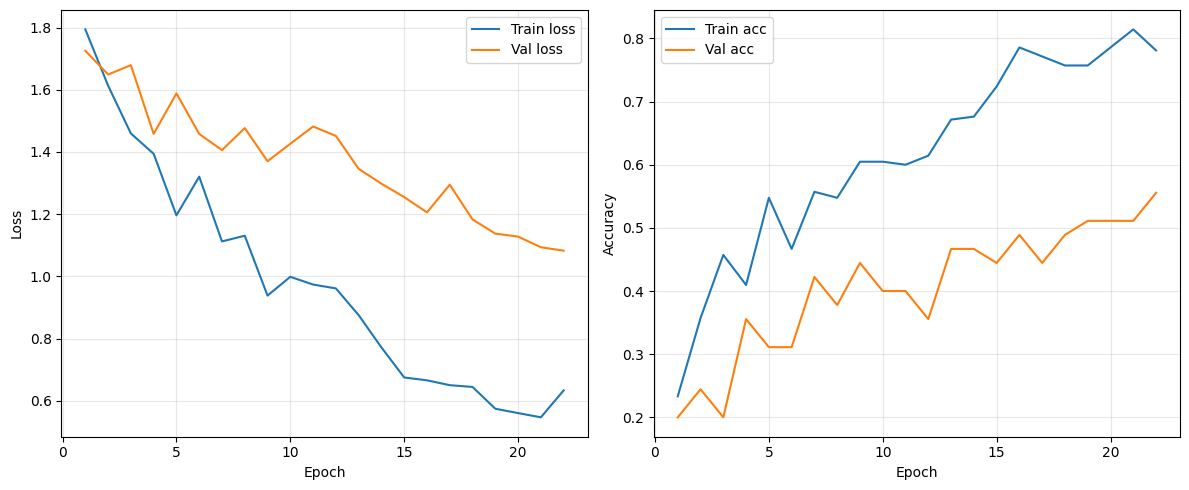

Legjobb val accuracy: 0.5556


In [10]:
epochs_range = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['train_loss'], label='Train loss')
plt.plot(epochs_range, history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['train_acc'], label='Train acc')
plt.plot(epochs_range, history['val_acc'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Legjobb val accuracy: {max(history['val_acc']):.4f}")


A legjobb modellt a teszthalmazon mérjük: pontosság, classification_report és konfúziós mátrix.


Test accuracy: 0.5556
Classification report:
              precision    recall  f1-score   support

           5       0.21      0.43      0.29         7
          10       0.00      0.00      0.00         7
          20       0.43      0.75      0.55         8
          50       0.75      0.38      0.50         8
         100       1.00      1.00      1.00         8
         200       1.00      0.71      0.83         7

    accuracy                           0.56        45
   macro avg       0.57      0.54      0.53        45
weighted avg       0.58      0.56      0.54        45



c:\Users\Bobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Bobo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

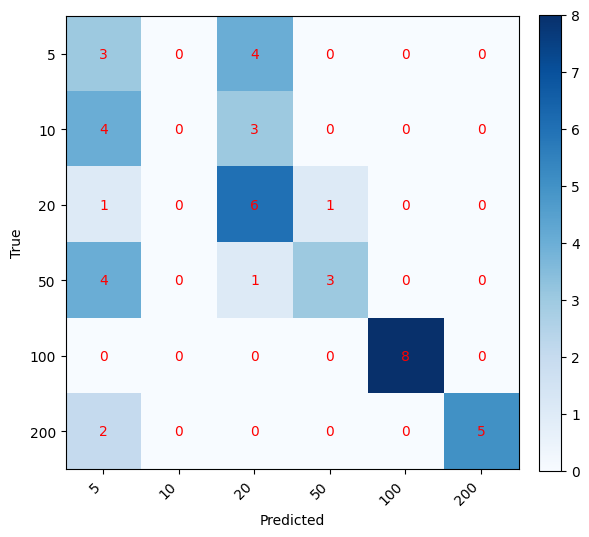

In [11]:
best_state = torch.load(best_state_path, map_location=device)
model.load_state_dict(best_state)
model.eval()

all_labels = []
all_preds = []
all_paths = []

with torch.no_grad():
    for images, labels, paths in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_paths.extend(paths)

test_acc = metrics.accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {test_acc:.4f}")
print('Classification report:')
print(metrics.classification_report(all_labels, all_preds, target_names=class_names))

cm = metrics.confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


### Hibás predikciók vizuálisan

Néhány hibás predikciót megnézünk vizuálisan.


Hibás példák száma: 20


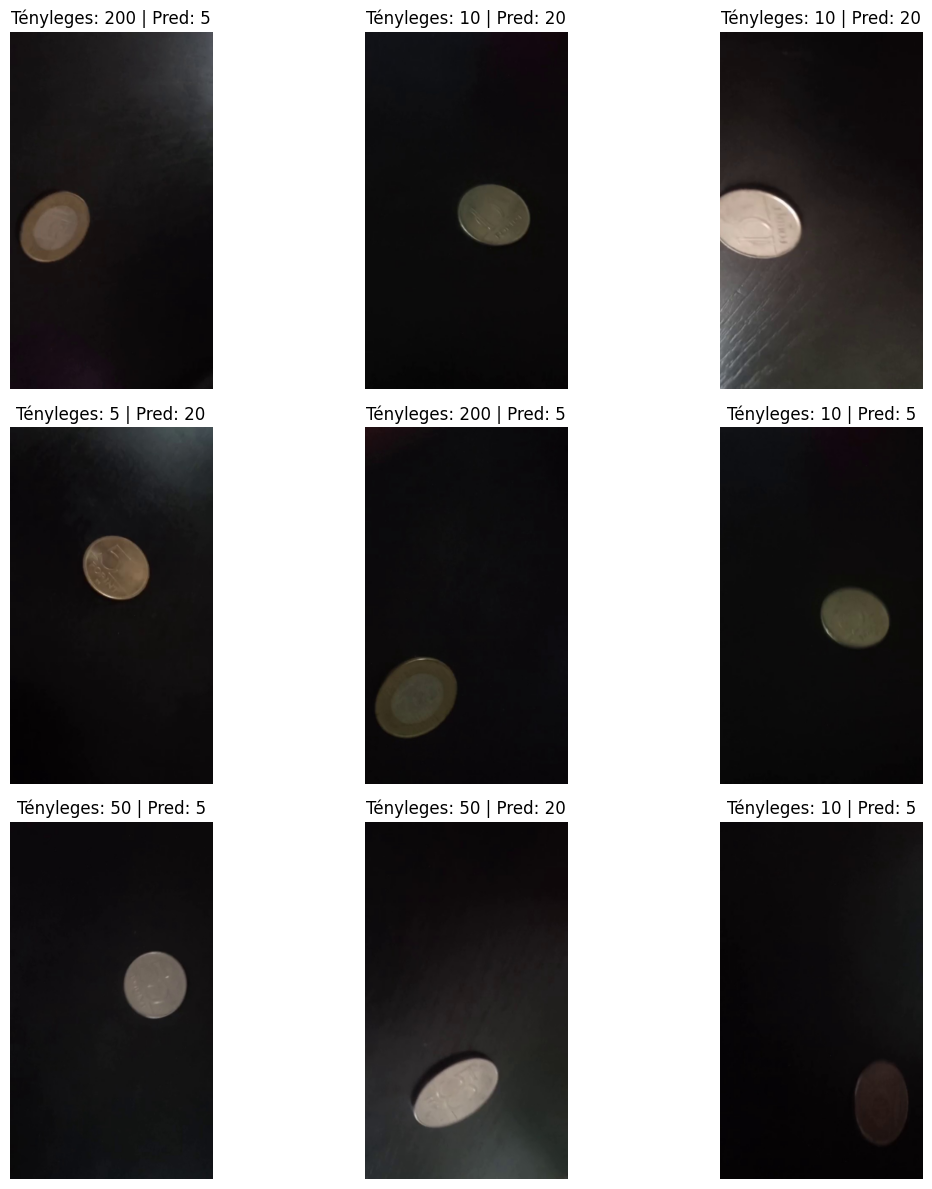

In [12]:
mis_idx = [i for i, (t, p) in enumerate(zip(all_labels, all_preds)) if t != p]
print(f"Hibás példák száma: {len(mis_idx)}")

if mis_idx:
    sample_idx = mis_idx[:9]
    n = len(sample_idx)
    cols = 3
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(12, 4 * rows))
    for i, idx in enumerate(sample_idx):
        path = all_paths[idx]
        img = Image.open(path).convert('RGB')
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        true_label = class_names[all_labels[idx]]
        pred_label = class_names[all_preds[idx]]
        plt.title(f"Tényleges: {true_label} | Pred: {pred_label}")
    plt.tight_layout()
    plt.show()


Egy függvény, ami tetszőleges képre kiírja a becsült címletet és valószínűséget.


### Inference predikciók

In [14]:
def predict_image(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(tensor)
        probs = torch.softmax(outputs, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)
    pred_class = class_names[pred_idx.item()]
    return pred_class, conf.item()

100 véletlen tesztkép kiértékelése (helyes/hibás)

In [15]:
# Legalább 100 véletlen tesztkép értékelése (vagy kevesebb, ha nincs 100 tesztminta)
num_samples = min(100, len(test_df))
sample_df = test_df.sample(n=num_samples, random_state=SEED).reset_index(drop=True)

results = []
correct_count = 0

for idx, row in sample_df.iterrows():
    img_path = row['path']
    true_label = row['label_name']  # pl. '5', '10', stb.
    pred_label, conf = predict_image(model, img_path, val_test_transform, class_names)
    is_correct = (pred_label == true_label)
    if is_correct:
        correct_count += 1
    results.append({
        'path': img_path,
        'true_label': true_label,
        'pred_label': pred_label,
        'confidence': conf,
        'correct': is_correct,
    })

total = len(results)
incorrect_count = total - correct_count

print(f"Minták száma: {total}")
print(f"Helyes predikciók: {correct_count}")
print(f"Hibás predikciók:  {incorrect_count}")
print(f"Pontosság ezen a 100 mintán: {correct_count / total:.4f}")

results_df = pd.DataFrame(results)
results_df.head()


Minták száma: 45
Helyes predikciók: 25
Hibás predikciók:  20
Pontosság ezen a 100 mintán: 0.5556


,path,true_label,pred_label,confidence,correct
0,images\50_forint_20.jpg,50,5,0.313138,False
1,images\200_forint_7.jpg,200,200,0.869890,True
2,images\5_forint_28.jpg,5,20,0.441301,False
3,images\10_forint_14.jpg,10,5,0.615242,False
4,images\20_forint_40.jpg,20,20,0.909854,True


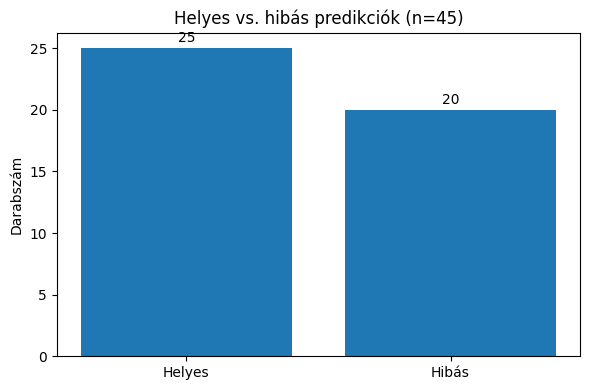

In [16]:
labels = ['Helyes', 'Hibás']
counts = [correct_count, incorrect_count]

plt.figure(figsize=(6, 4))
plt.bar(labels, counts)
plt.ylabel('Darabszám')
plt.title(f'Helyes vs. hibás predikciók (n={total})')
for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center')
plt.tight_layout()
plt.show()

## Összefoglaló

A projektben saját fotózott érmeadatbázist használtam, és a VGG16 előre tanított modelljére építve készítettem egy érmefelismerő rendszert. A kevés rendelkezésre álló kép miatt különböző augmentációs technikákat alkalmaztam (vágás, forgatás, tükrözés, fényerő–kontraszt módosítás), hogy a modell minél többféle helyzetet megtanuljon kezelni. A legjobb modell kiválasztása validáció alapján történt, majd ezt használtam a teszteléshez. A hibás példákat külön is megvizsgáltam, így jól láthatóvá vált, mely címleteket keveri leginkább a modell és milyen helyzetekben. A végeredmény körülbelül 55–60% pontosság lett, ami a kis adatmennyiség és az érmék hasonló megjelenése miatt teljesen reális.

A tanítást két lépésben végeztem. Először csak a háló úgynevezett „fejét”, vagyis a legfelső, döntést hozó rétegeket tanítottam újra a saját adataimra. Ezek felelősek azért, hogy a háló végül eldöntse, melyik osztályba tartozik a bemenet. A VGG16 mélyebb, konvolúciós rétegeihez ekkor még nem nyúltam hozzá, mert ezek már eleve jól megtanulták az általános vizuális mintákat (élek, textúrák, formák) az ImageNet tanítása során. Miután a felső réteg stabilan működött, feloldottam a modell utolsó konvolúciós blokkját is, és nagyon kis tanulási rátával finomhangoltam. Ez azért fontos lépés, mert így a háló kicsit jobban hozzá tud igazodni az érmeképekre jellemző apró részletekhez, miközben nem rontja le az alsóbb rétegekben lévő általános tudást.

Végül készítettem egy külön függvényt is, amivel új, saját képekre lehet előrejelzést kérni. A projekt során így végigmentem a teljes folyamaton: adat-előkészítés, augmentáció, transfer learning, finomhangolás, kiértékelés és új képek osztályozása. A tapasztalatok alapján még több kép hozzáadásával és az augmentáció finomhangolásával tovább lehetne növelni a pontosságot.